# Import modules

In [1]:
import os
import shutil
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Set global parameter

In [2]:
BASE_DIR = Path("/kaggle/input/hms-harmful-brain-activity-classification")

EEG_SAMPLING_TIME = 50  #second
EEG_SAMPLING_RATE = 200 #Hz
EEG_DURATION = EEG_SAMPLING_RATE * EEG_SAMPLING_TIME

In [3]:
train_df = pd.read_csv(BASE_DIR/"train.csv")
print(f"{len(train_df)=}")
print(f"train df nan:{train_df.isna().sum().sum()}")
train_df.head(100)

len(train_df)=106800
train df nan:0


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,893864755,5,30.0,4367732,5,30.0,1523697063,2338,Other,0,0,0,0,3,10
96,3669581453,0,0.0,4546138,0,0.0,3616273655,57448,LRDA,0,0,0,3,0,0
97,3669581453,1,4.0,4546138,1,4.0,2864762111,57448,LRDA,0,0,0,3,0,0
98,3669581453,2,6.0,4546138,2,6.0,1822146963,57448,LRDA,0,0,0,3,0,0


In [4]:
label_unique = train_df.expert_consensus.unique().tolist()
label_unique

['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD']

In [5]:
vote_df = train_df[list(map(lambda s: s.lower()+'_vote', label_unique))].copy()
ratiovote_df = vote_df.apply(lambda x: x/x.sum(), axis=1)
expert_consensus_prob_series = ratiovote_df.apply(lambda x: x.max(), axis=1)

<Axes: ylabel='Frequency'>

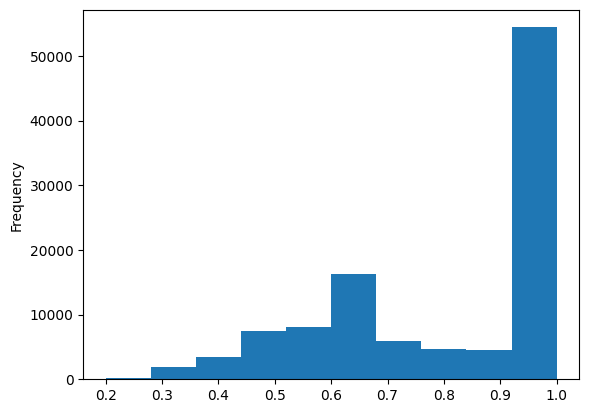

In [6]:
expert_consensus_prob_series.plot.hist(bins=10)

In [7]:
train_df.loc[expert_consensus_prob_series.sort_values(ascending=True).index.tolist()].to_csv('not_consensus.csv')

In [8]:
def get_train_eeg(q:dict) -> pd.DataFrame:
    parquet_df = pd.read_parquet(BASE_DIR/f"train_eegs/{q['eeg_id']}.parquet")
    eeg_start_index = int(EEG_SAMPLING_RATE * q["eeg_label_offset_seconds"])
    return parquet_df.iloc[eeg_start_index:eeg_start_index+EEG_DURATION]

def plot_eeg(df, moving_avg=1):
    fig, axs = plt.subplots(20, 1, figsize=(30, 15), sharex=True)
    for i, ax in enumerate(axs):
        ax.plot(df.iloc[:,i], color="black")
        for vline in df[df.iloc[:,i].isna()].index:
            line_min = df.iloc[:,i].min()
            line_max = df.iloc[:,i].max()
            ax.vlines(vline, line_min, line_max, color='red')
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)

In [9]:
def save_all_eeg_img(p_eeg):
    eeg = pd.read_parquet(p_eeg)
    plot_eeg(eeg)
    plt.savefig(f'all_eeg_figs/{p_eeg.split("/")[-1].split(".")[0]}.png')
    plt.close()

In [10]:
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='db8', level=1): # dmeyがてんかん患者のEEG信号からのノイズ除去に最適であり、db8が健康な被験者のEEG信号からのノイズ除去に最適
    ret = {key:[] for key in x.columns}
    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])
        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    return pd.DataFrame(ret)

isna# Sample Vizulization

In [11]:
q = train_df.iloc[10]
q = dict(q)
q["expert_consensus"]

'GPD'

## raw data

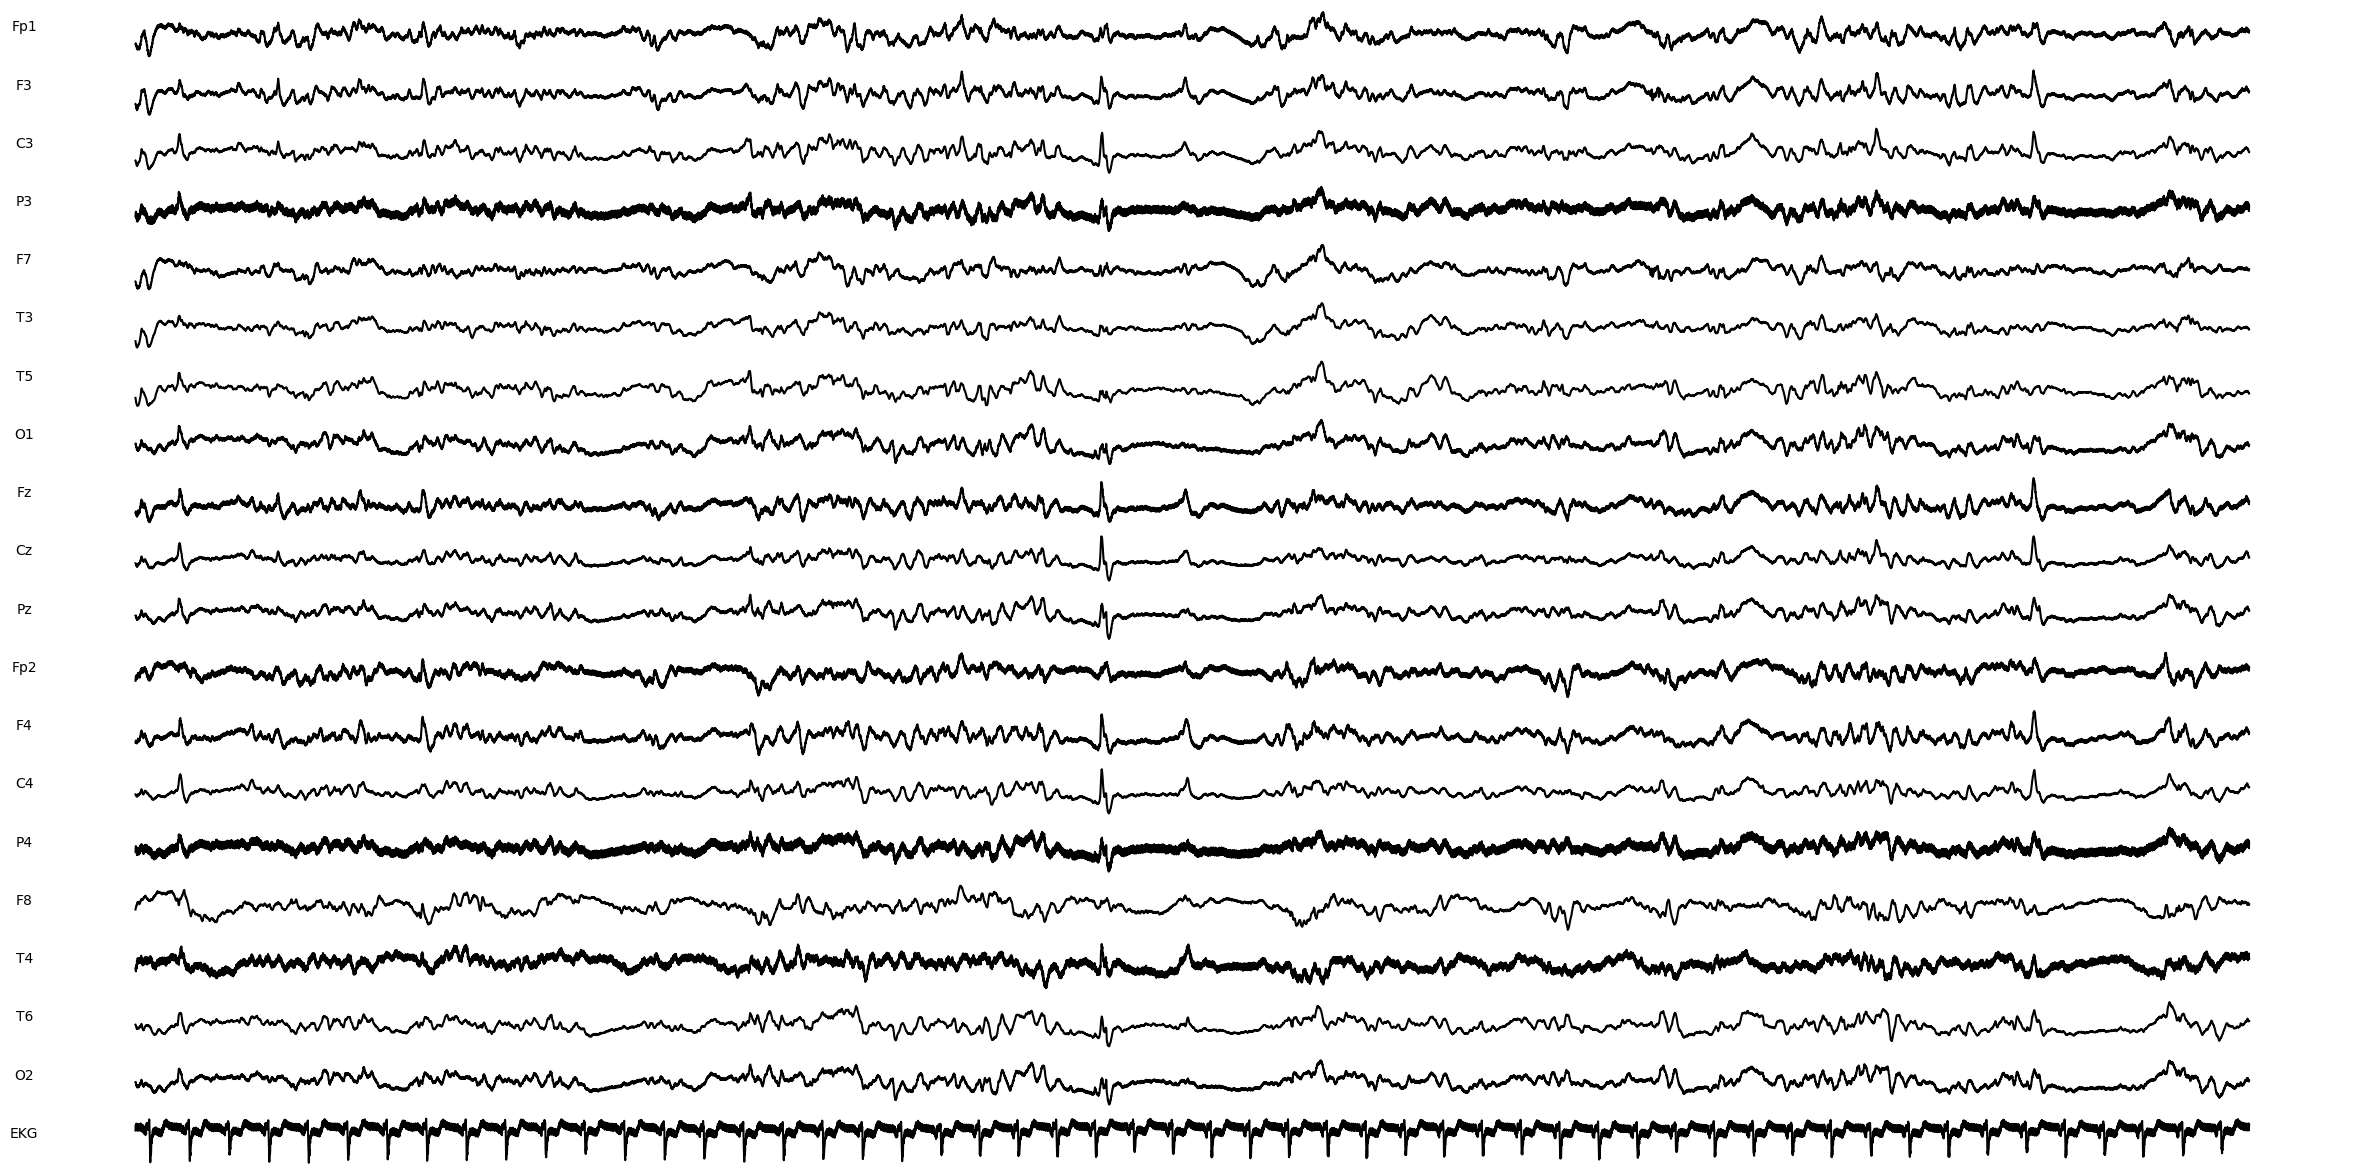

In [12]:
eeg = get_train_eeg(q)
plot_eeg(eeg)

## db8 is best for removing noise from EEG signals of healthy patients

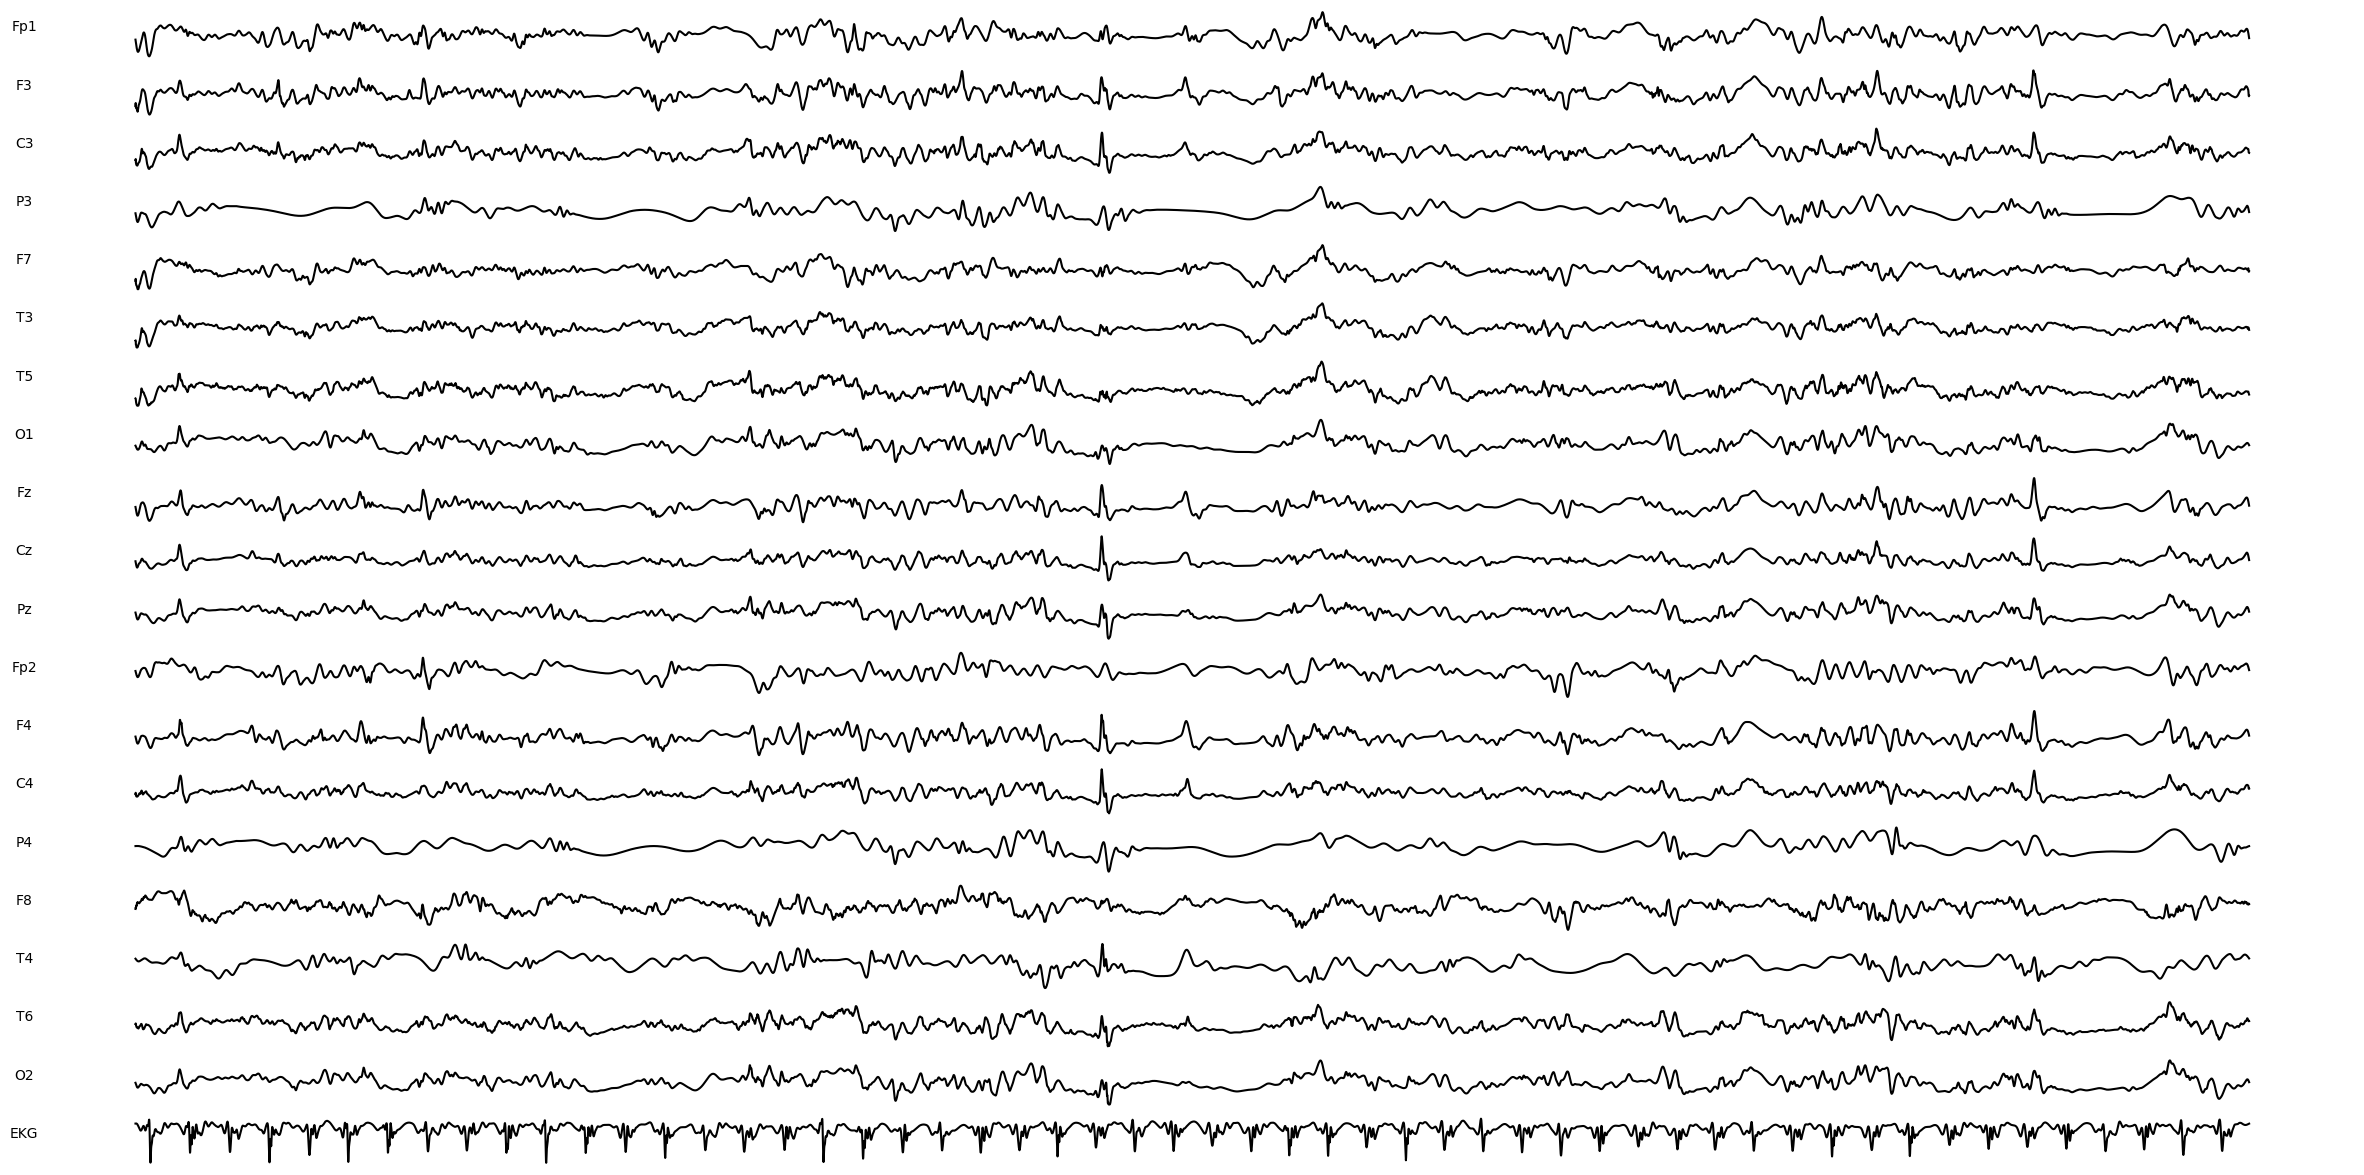

In [13]:
db8_processed_eeg = denoise(eeg, wavelet="db8")
plot_eeg(db8_processed_eeg)

## dmey is best for removing noise from EEG signals of epilepsy patients

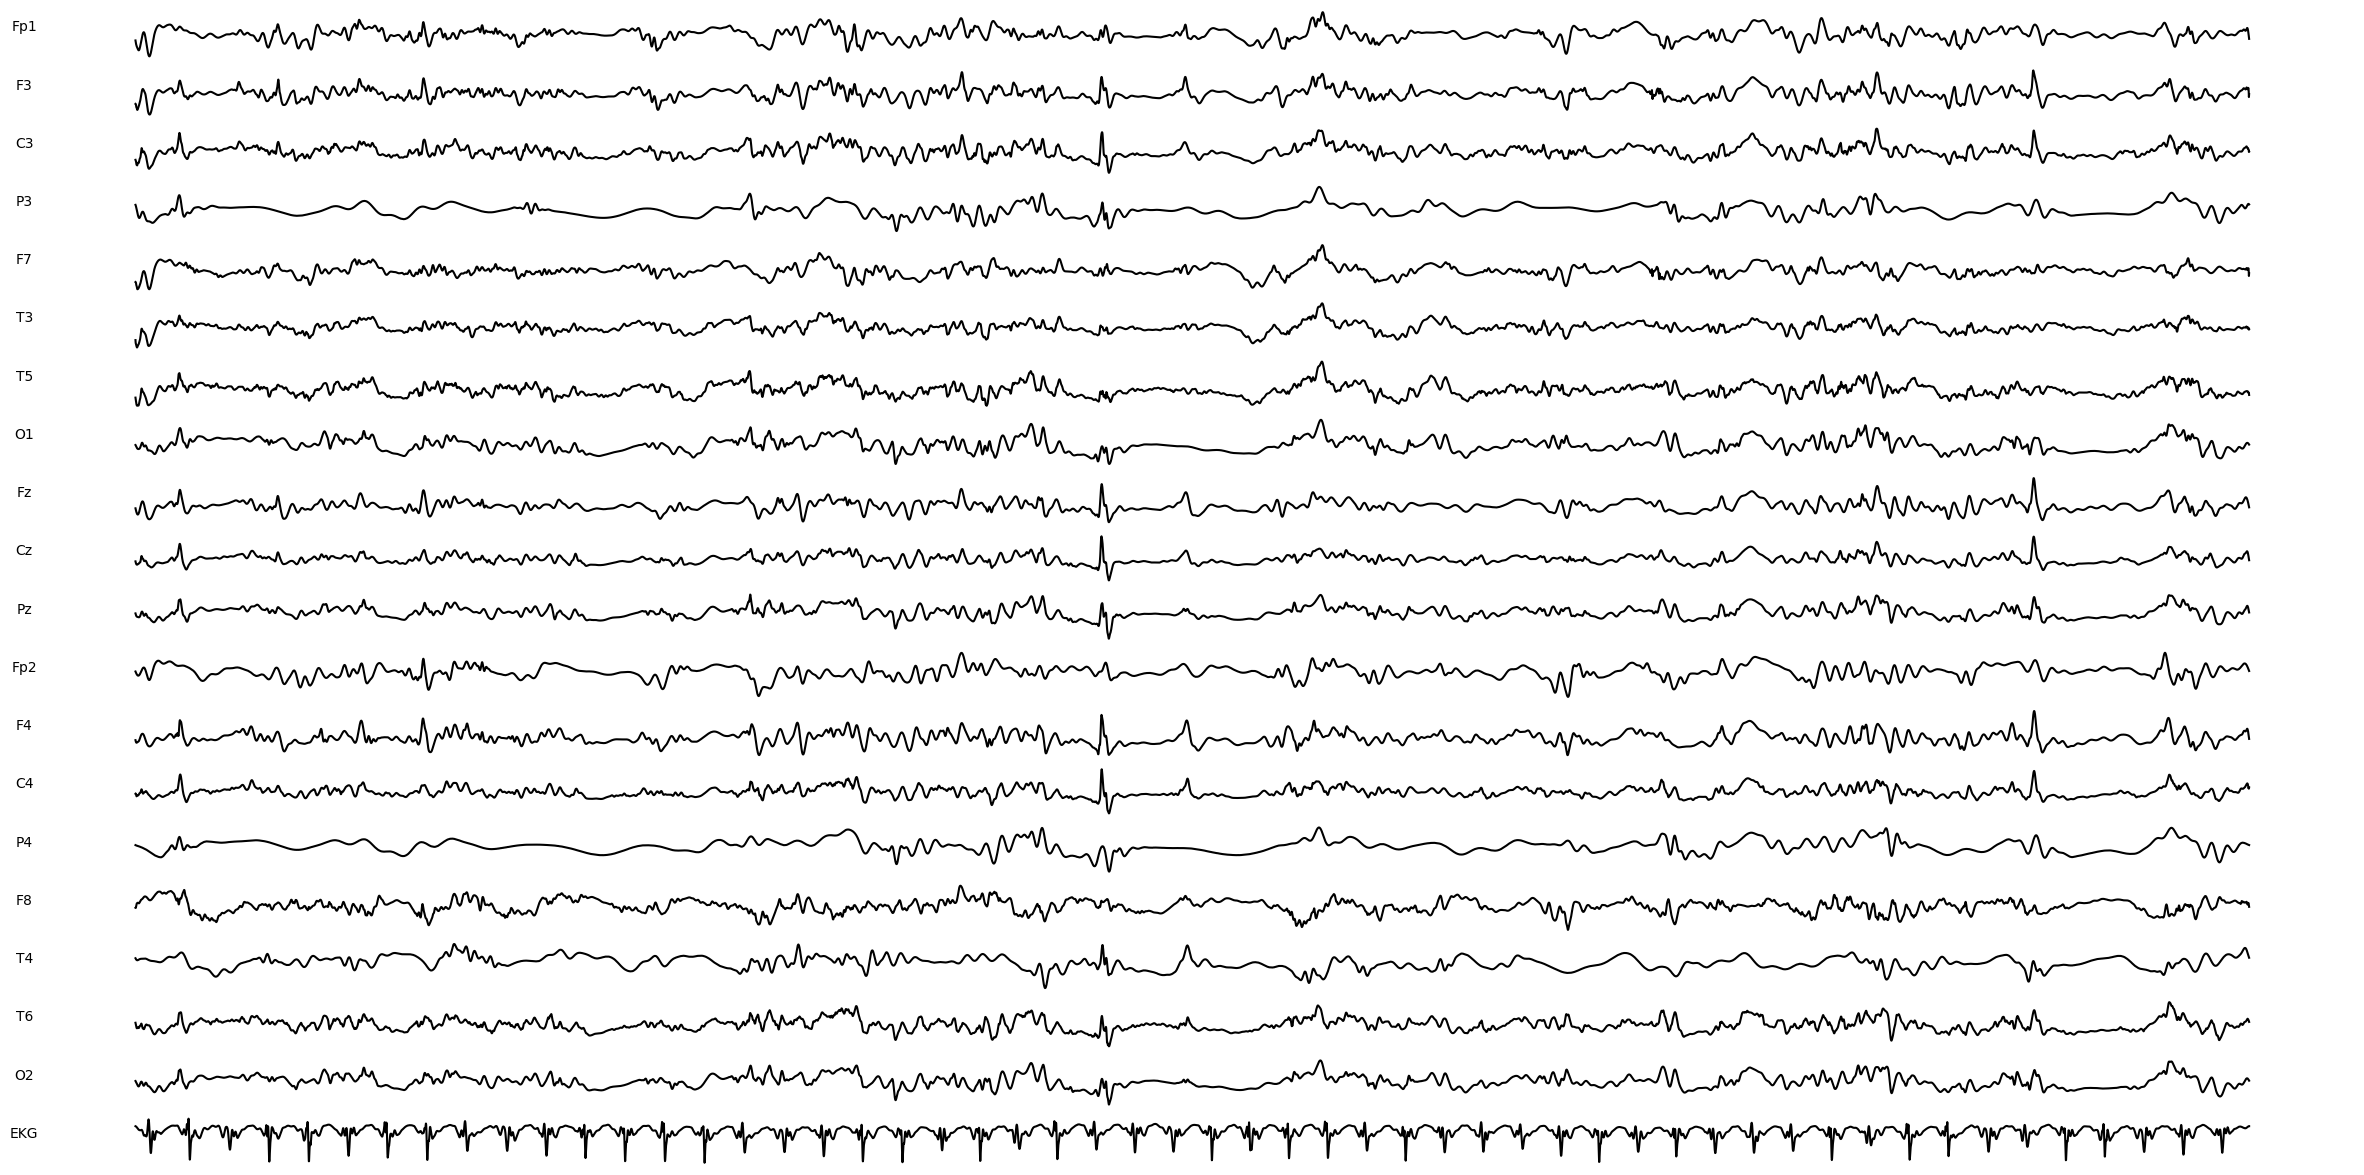

In [14]:
dmey_processed_eeg = denoise(eeg, wavelet="dmey")
plot_eeg(dmey_processed_eeg)

# Serch missing value eeg index

In [15]:
def detect_na(row):
    if get_train_eeg(row).isna().sum().sum():
        return f"{row['eeg_id']}-{row['eeg_sub_id']}"

In [16]:
fig_out_dir = "all_eeg_figs"
os.makedirs(fig_out_dir, exist_ok=True)

# I don't like run so long, that's why I make branch of runtype, if you want to run all in interactive, you should use only Batch block.
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("Running on Interactive Notebook")
    temp_train_df = train_df.sample(100).copy()
    drop_index = joblib.Parallel(n_jobs=-1)(joblib.delayed(detect_na)(row) for i, row in temp_train_df.iterrows())
    joblib.Parallel(n_jobs=-1)(joblib.delayed(save_all_eeg_img)(p_eeg) for p_eeg in glob.glob(os.path.join(BASE_DIR, "train_eegs/*"))[:10])
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("Running on Background Notebook")
    joblib.Parallel(n_jobs=-1)(joblib.delayed(save_all_eeg_img)(p_eeg) for p_eeg in glob.glob(os.path.join(BASE_DIR, "train_eegs/*")))
    drop_index = joblib.Parallel(n_jobs=-1)(joblib.delayed(detect_na)(row) for i, row in train_df.iterrows())
    
drop_index = list(filter(None, drop_index))

Running on Background Notebook


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
print(f"detect {len(drop_index)=}")
joblib.dump(drop_index, "dropped-eeg-id-sub.joblib")

detect len(drop_index)=3542


['dropped-eeg-id-sub.joblib']

In [18]:
unique_missingvalue_set = set()
for drp_idx in drop_index:
    eedid, eegsubid = map(int, drp_idx.split("-"))
    row = dict(train_df.loc[(train_df.eeg_id==eedid)&(train_df.eeg_sub_id==eegsubid),:].iloc[0])
    na_eeg = get_train_eeg(row)
    unique_missingvalue_set.add(*set(na_eeg.isna().sum()))
    if len(set(na_eeg.isna().sum()))!=1:
        print("partial missing value is exit!")
else:
    print("all missing value is same time line")
print("-"*50)
print(f"each eeg missing value range: {min(unique_missingvalue_set)} ~ {max(unique_missingvalue_set)}")

all missing value is same time line
--------------------------------------------------
each eeg missing value range: 1 ~ 5197


LRDA


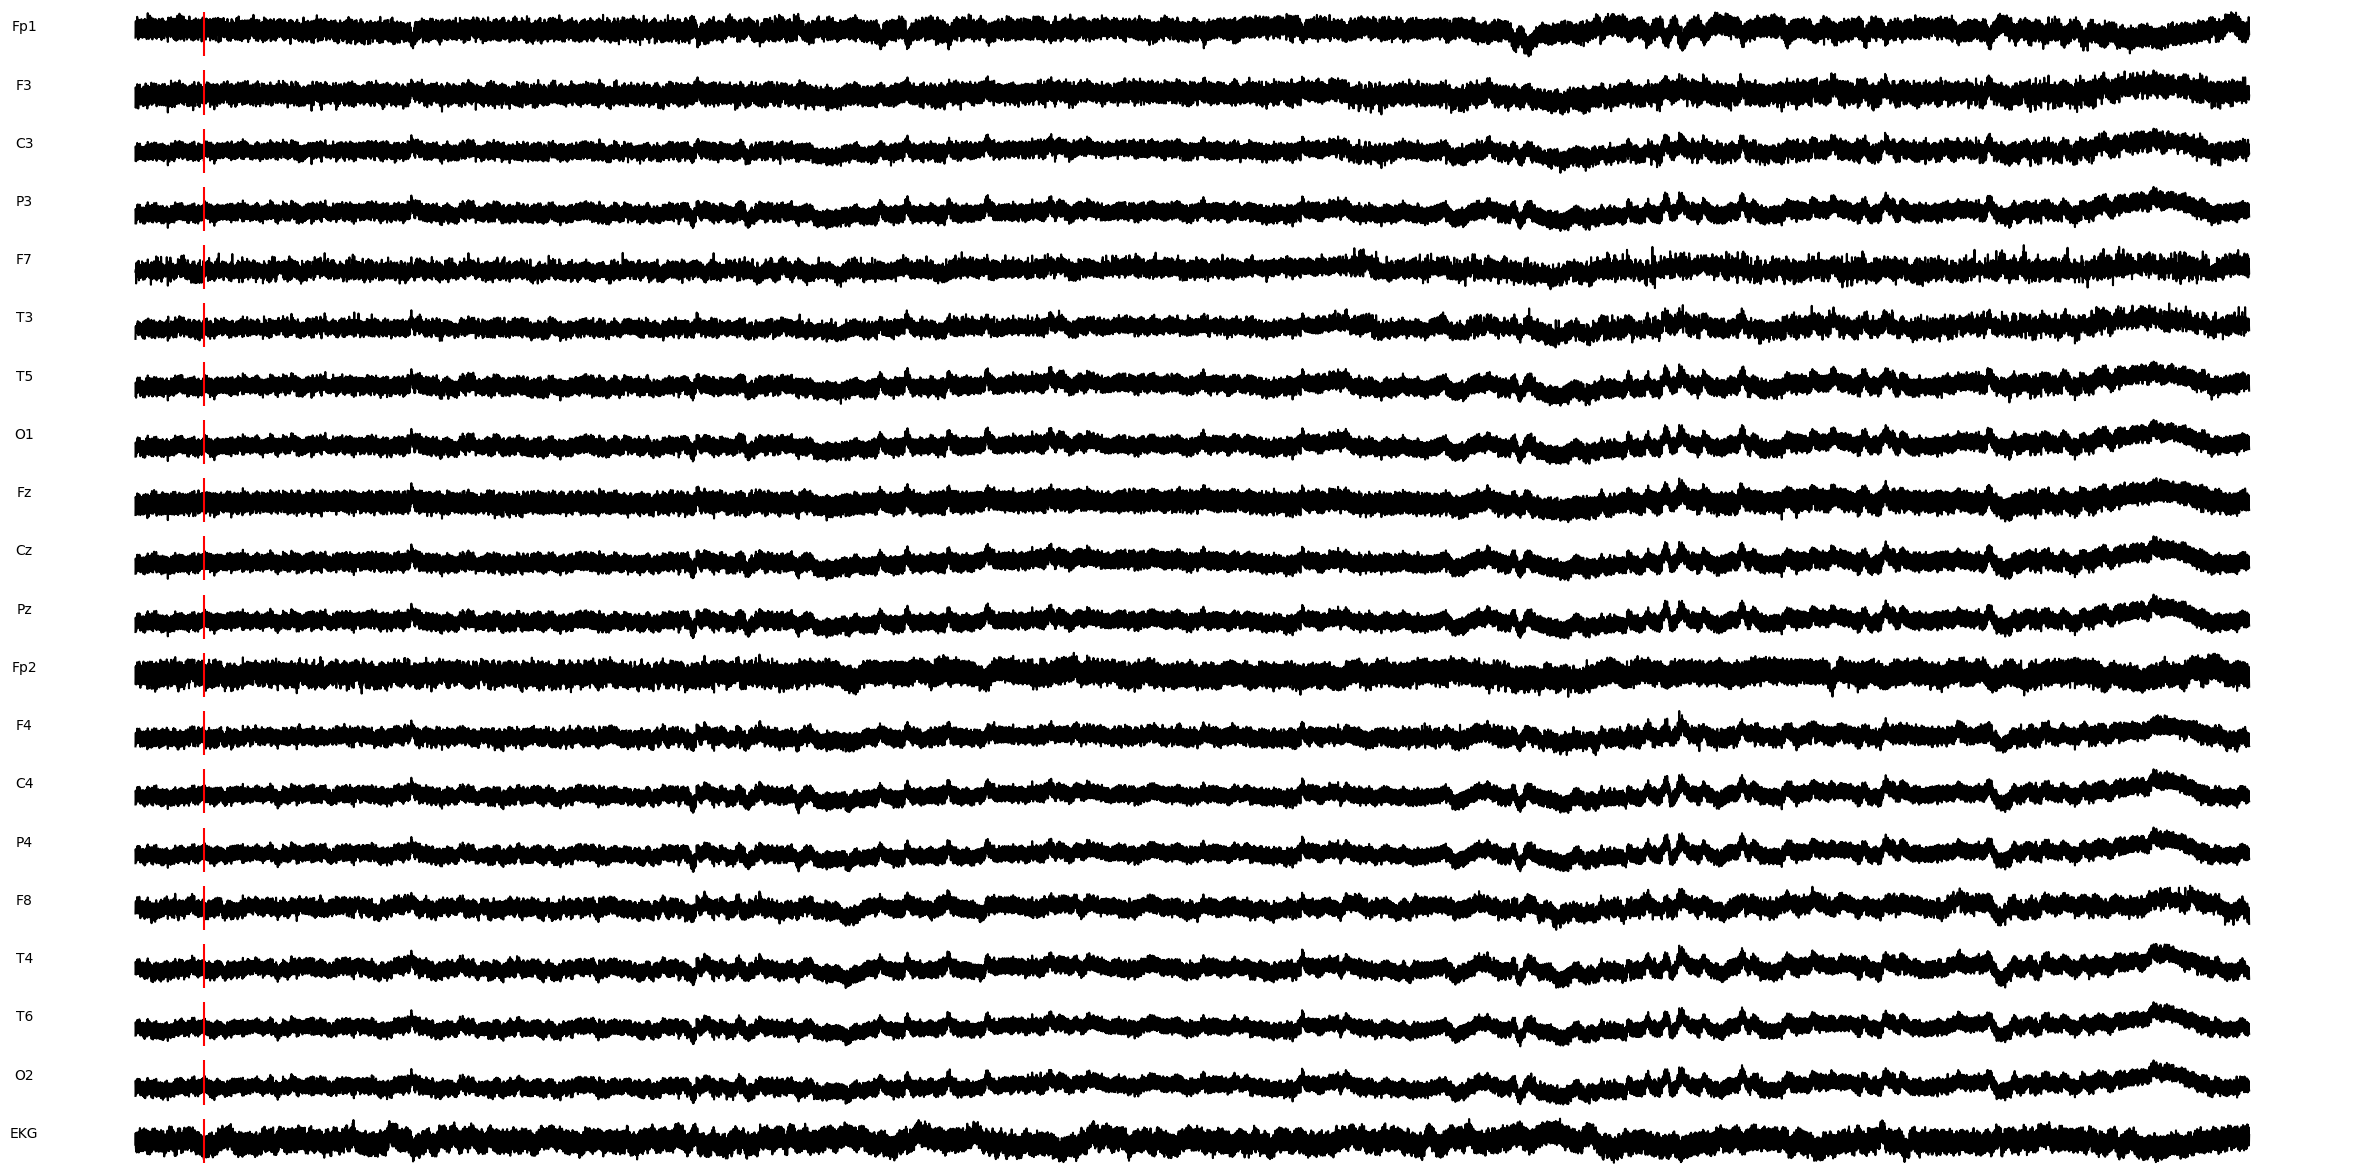

In [19]:
print(row["expert_consensus"])
na_eeg = get_train_eeg(row)
plot_eeg(na_eeg)

# Search outlier value